# **Import the libraries**

In [1]:
# Importing necessary libraries
import os
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing NLP libraries and resources
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# Importing TensorFlow/Keras components for model building
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, concatenate, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical

# Silence warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')

# Optional: Silence Keras-related warnings if necessary
import keras.utils as ku

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Dataset Loading**

In [2]:
df = pd.read_csv('/kaggle/input/reviews-shl/reviews_supplements.csv')

In [3]:
#Print First 5 rows
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,4,B Complex in gel cap form,I bought this along with Vit C in gel cap form...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37
1,5,Five Stars,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11
2,5,Five Stars,Came as expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15
3,5,Vitamin Shoppe Dry Vitamin A,Excellent Product ..... Fast Delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33
4,5,Un producto que compro regularmente,Es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11


In [4]:
df.shape

(16669, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16669 entries, 0 to 16668
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             16669 non-null  int64 
 1   title              16662 non-null  object
 2   text               16664 non-null  object
 3   asin               16669 non-null  object
 4   parent_asin        16669 non-null  object
 5   user_id            16669 non-null  object
 6   timestamp          16669 non-null  object
 7   helpful_vote       16669 non-null  int64 
 8   verified_purchase  16669 non-null  bool  
 9   date               16669 non-null  object
 10  time               16669 non-null  object
dtypes: bool(1), int64(2), object(8)
memory usage: 1.3+ MB


In [6]:
#check null values
df.isnull().sum()

rating               0
title                7
text                 5
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
date                 0
time                 0
dtype: int64

In [ ]:
#Drop the null elements
df = df.dropna()

In [8]:
df.shape

(16658, 11)

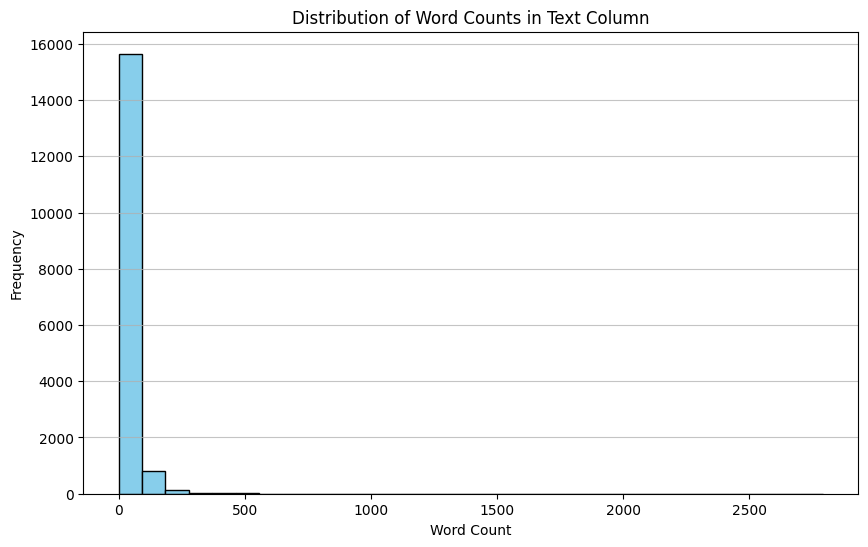

In [9]:
# Calculate the number of words in each text in the 'text' column
word_counts = df['text'].dropna().str.split().str.len()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Text Column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


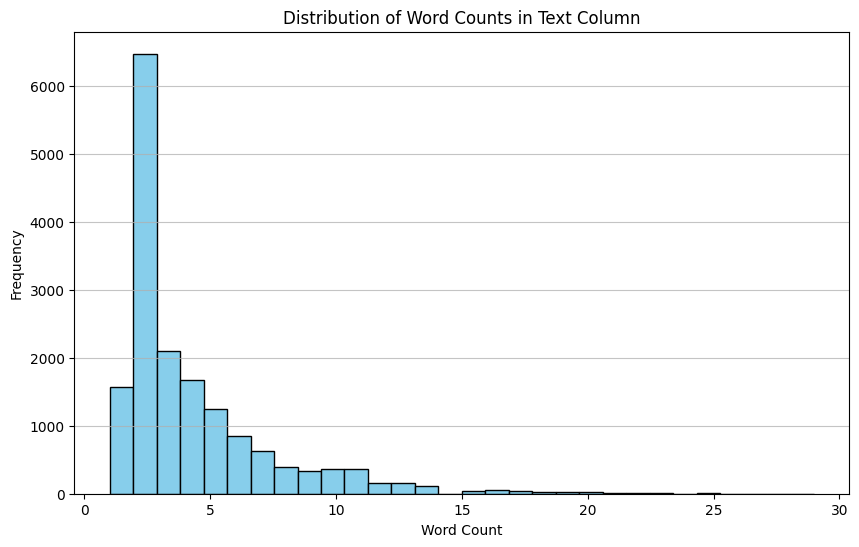

In [10]:
#word count for title column

word_counts = df['title'].dropna().str.split().str.len()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Text Column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
# value count for rating column

df['rating'].value_counts()

rating
5    11201
1     2028
4     1752
3      955
2      722
Name: count, dtype: int64

In [12]:
#value count for verified purchase column

df['verified_purchase'].value_counts()

verified_purchase
True    16658
Name: count, dtype: int64

# **Data Preprocessing**

In [13]:
#Standard Scale the values of rating column

from sklearn.preprocessing import StandardScaler
rating_values = df['rating'].values.reshape(-1, 1)
scaler = StandardScaler()
df['rating'] = scaler.fit_transform(rating_values)

In [14]:
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,-0.116186,B Complex in gel cap form,I bought this along with Vit C in gel cap form...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37
1,0.595891,Five Stars,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11
2,0.595891,Five Stars,Came as expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15
3,0.595891,Vitamin Shoppe Dry Vitamin A,Excellent Product ..... Fast Delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33
4,0.595891,Un producto que compro regularmente,Es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11


In [15]:
nlp = spacy.load('en_core_web_sm')

# Function to clean text using spaCy
def clean_text(txt):
    doc = nlp(txt)
    cleaned_words = [token.lemma_.lower() for token in doc if not token.is_stop]
    return ' '.join(cleaned_words)

In [16]:
# Clean the 'text' and 'title' columns
df['text'] = df['text'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)

# Combine 'title' and 'text' into a single sequence
df['combined_text'] = df['title'] + ' ' + df['text']                                           

In [17]:
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time,combined_text
0,-0.116186,b complex gel cap form,buy vit c gel cap form doctor explain website ...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,11-12-2009 00:37,1,True,11-12-2009,00:37,b complex gel cap form buy vit c gel cap form ...
1,0.595891,star,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,04-01-2015 03:11,0,True,04-01-2015,03:11,star great product
2,0.595891,star,come expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,27-09-2015 19:15,0,True,27-09-2015,19:15,star come expectedly
3,0.595891,vitamin shoppe dry vitamin,excellent product ..... fast delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,33:16.9,0,True,09-02-2019,19:33,vitamin shoppe dry vitamin excellent product ....
4,0.595891,un producto que compro regularmente,es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,11:10.9,0,True,25-07-2022,14:11,un producto que compro regularmente es muy bue...


In [18]:
# Initialize the Tokenizer with a limited vocabulary size

max_words = 9000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['combined_text'])

In [19]:
# Define maximum sequence length
max_sequence_len = 80

In [20]:
# Function to generate sequences and associate ratings
def generate_sequences_with_ratings(texts, ratings, tokenizer):
    sequences = []
    ratings_list = []
    for text, rating in zip(texts, ratings):
        token_list = tokenizer.texts_to_sequences([text])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            if len(n_gram_sequence) > max_sequence_len:
                n_gram_sequence = n_gram_sequence[-max_sequence_len:]
            sequences.append(n_gram_sequence)
            ratings_list.append(rating)
    return sequences, ratings_list

In [21]:
# Generate sequences and associated ratings
input_sequences, ratings_list = generate_sequences_with_ratings(df['combined_text'], df['rating'], tokenizer)

# Pad sequences
padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')


In [22]:
# Separate predictors and label
predictors, label = padded_sequences[:, :-1], padded_sequences[:, -1]

# One-hot encode labels
label = to_categorical(label, num_classes=max_words)

# Convert ratings list to numpy array
ratings_array = np.array(ratings_list)


# **Model Architecture**

In [23]:
# Define the model with attention mechanism
def create_model_with_attention(max_words, max_sequence_len):
    # Input for text sequences
    input_seq = Input(shape=(max_sequence_len - 1,))
    x = Embedding(max_words, 100, input_length=max_sequence_len - 1)(input_seq)

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Apply attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention

    # Global average pooling
    attention_out = GlobalAveragePooling1D()(attention)

    # Input for rating
    input_rating = Input(shape=(1,))

    # Concatenate attention output and rating input
    combined = concatenate([attention_out, input_rating])

    # Fully connected layers
    dense_out = Dense(128, activation='relu')(combined)
    drop_out = Dropout(0.3)(dense_out)

    # Output layer
    output_layer = Dense(max_words, activation='softmax')(drop_out)

    # Define the model with two inputs and one output
    model = Model(inputs=[input_seq, input_rating], outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Create and compile the model
model = create_model_with_attention(max_words, max_sequence_len)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 79)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 79, 100)   │    900,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 79, 256)   │    234,496 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 79, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 257)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9000)      │  1,161,000 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,328,520 (8.88 MB)

 Trainable params: 2,328,520 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Trianing**

In [24]:
# Train the model
batch_size = 35
epochs = 80

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=2)

history = model.fit(
    [predictors, ratings_array],
    label,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping]
)

print("Model training completed.")

Epoch 1/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 7.1859
Epoch 2/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 6.7533
Epoch 3/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 6.4889
Epoch 4/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 6.3148
Epoch 5/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 6.1620
Epoch 6/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 6.0438
Epoch 7/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 5.9447
Epoch 8/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - loss: 5.8402
Epoch 9/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 5.7582
Epoch 10/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 5.6826
Epoch 11/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 5.6154
Epoch 12/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - loss: 5.5479
Epoch 13/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 5.4846
Epoch 14/80
7256/7256 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 5.4264
E

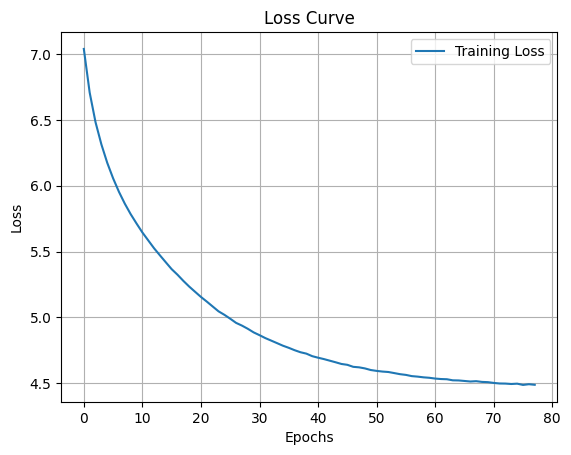

In [26]:
import matplotlib.pyplot as plt

# Plot the loss curve
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss diagram
plot_loss(history)


# **TESTING**

In [41]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Function to apply temperature to the model's predictions
def apply_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-9) / temperature  # Apply temperature
    exp_preds = np.exp(preds)
    return exp_preds / np.sum(exp_preds)

# Function to generate a review with temperature
def generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate=20, temperature=1.0):
    cleaned_seed_text = clean_text(seed_text)  # Use your existing clean_text function
    token_list = tokenizer.texts_to_sequences([cleaned_seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    generated_text = seed_text
    
    for _ in range(num_words_to_generate):
        predicted_probs = model.predict([token_list, np.array([[rating_value]])], verbose=0)[0]
        predicted_probs = apply_temperature(predicted_probs, temperature)       
        predicted_word_index = np.random.choice(range(max_words), p=predicted_probs)
        if predicted_word_index == 0:
            break
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        generated_text += ' ' + predicted_word
        token_list = np.append(token_list, [[predicted_word_index]], axis=1)
        token_list = pad_sequences([token_list[0]], maxlen=max_sequence_len - 1, padding='pre')

    return generated_text

seed_text = "The supplement"
rating_value = 0.75  
num_words_to_generate = 20  
temperature = 1.0  

generated_review = generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate, temperature)
print("Generated Review: ", generated_review)


Generated Review:  The supplement type vitamin year gummie great try coconut help quality like yogurt sad family friend tell prescribe improve omega vitamin beauty


In [38]:
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu


reference_texts = df['combined_text'].tolist()  

def calculate_bleu_score(reference_texts, generated_text):
    reference_tokens = [ref.split() for ref in reference_texts]  
    generated_tokens = generated_text.split()  
    
    bleu_score = sentence_bleu(reference_tokens, generated_tokens)
    
    return bleu_score

seed_text = "The supplement"
rating_value = 0.75  
num_words_to_generate = 20  
temperature = 0.7  

generated_review = generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate, temperature)
print("Generated Review: ", generated_review)

bleu_score = calculate_bleu_score(reference_texts, generated_review)
print(f"BLEU Score: {bleu_score}")


Generated Review:  The supplement great great product compare try complete vitamin possible woman supplementation receive amazon 120 3 retail store doc find great price
BLEU Score: 0.4497332084013506


In [40]:
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu

reference_texts = df['combined_text'].tolist()  # Extracting original reviews as reference texts

# Function to calculate BLEU score
def calculate_bleu_score(reference_texts, generated_text):
    reference_tokens = [ref.split() for ref in reference_texts]  
    generated_tokens = generated_text.split()  
    bleu_score = sentence_bleu(reference_tokens, generated_tokens)
    return bleu_score

# Generate a review 
seed_text = "The supplement"
rating_value = 0.66  
num_words_to_generate = 20  
temperature = 1.0  

generated_review = generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate, temperature)
print("Generated Review: ", generated_review)

bleu_score = calculate_bleu_score(reference_texts, generated_review)
print(f"BLEU Score: {bleu_score}")


Generated Review:  The supplement far far like reading 2000 or total 2 new place time great early morning happen receive 100 edit reach people
BLEU Score: 0.7671309447131562


# **Generate CSV file of synthetic data**

In [56]:
# Function to apply temperature to the model's predictions
def apply_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-9) / temperature  # Apply temperature
    exp_preds = np.exp(preds)
    return exp_preds / np.sum(exp_preds)

In [62]:
# Function to generate a review with temperature
def generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate=20, temperature=1.0):
    cleaned_seed_text = clean_text(seed_text)  # Clean the seed text
    token_list = tokenizer.texts_to_sequences([cleaned_seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    
    generated_text = seed_text
    
    for _ in range(num_words_to_generate):
        predicted_probs = model.predict([token_list, np.array([[rating_value]])], verbose=0)[0]
        predicted_probs = apply_temperature(predicted_probs, temperature)
        predicted_word_index = np.random.choice(range(max_words), p=predicted_probs)
        
        if predicted_word_index == 0:  # Stop if padding token is predicted
            break
        
        predicted_word = tokenizer.index_word.get(predicted_word_index, '')
        generated_text += ' ' + predicted_word
        
        token_list = np.append(token_list, [[predicted_word_index]], axis=1)
        token_list = pad_sequences([token_list[0]], maxlen=max_sequence_len - 1, padding='pre')

    return generated_text.strip()

In [63]:
# Parameters for generation
seed_texts = [
    "The supplement",
    "This product",
    "I really enjoyed",
    "Absolutely love",
    "Not sure about",
    "Would recommend",
    "Fantastic experience",
    "Quality is top-notch",
    "Value for money",
    "Would buy again"
]
rating_value = 0.75  # Example rating value
num_reviews = 200  # Total reviews to generate
lengths = [10, 20, 30]  # Different lengths of reviews to generate
temperatures = [0.7, 1.0, 1.5]  # Different temperature values

In [64]:
# Initialize a list to store the generated reviews
generated_reviews = []

# Generate reviews
for length in lengths:
    for temperature in temperatures:
        for seed_text in seed_texts:  
            for _ in range(num_reviews // (len(lengths) * len(temperatures) * len(seed_texts))):
                review = generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, length, temperature)
                generated_reviews.append({
                    'review': review,
                    'length': length,
                    'temperature': temperature,
                    'seed_text': seed_text
                })

In [65]:
# Convert the generated reviews to a DataFrame
reviews_df = pd.DataFrame(generated_reviews)

# Save the DataFrame to a CSV file
reviews_df.to_csv('generated_reviews.csv', index=False)

print(f"Total generated reviews: {len(generated_reviews)}")
print("Reviews saved to 'generated_reviews.csv'")

Total generated reviews: 180
Reviews saved to 'generated_reviews.csv'


# **BLEU SCORE**

In [67]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_mean_bleu_score(generated_reviews, reference_texts):
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_texts]
    
    bleu_scores = []
    for review in generated_reviews:
        generated_tokens = nltk.word_tokenize(review)
        bleu_score = sentence_bleu(reference_tokens, generated_tokens)
        bleu_scores.append(bleu_score)
    
    return np.mean(bleu_scores)


reference_texts = df['combined_text'].tolist()

# Calculate the mean BLEU score for the generated reviews
mean_bleu_score = calculate_mean_bleu_score([review['review'] for review in generated_reviews], reference_texts)

print(f"Mean BLEU Score: {mean_bleu_score}")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mean BLEU Score: 0.5732641484021787


# **TESTING**

In [71]:
review_lengths = [10, 13, 15, 18, 20]

seed_texts = [
    "The supplement",
    "This product",
    "I really enjoyed",
    "Absolutely love",
    "Not sure about"
]

generated_reviews = []
for i in range(5):
    seed_text = seed_texts[i]
    length = review_lengths[i]
    review = generate_review_with_temperature(model, tokenizer, seed_text, max_sequence_len, max_words, rating_value, num_words_to_generate=length, temperature=1.0)
    generated_reviews.append({
        'seed_text': seed_text,
        'length': length,
        'review': review
    })

# Print the generated reviews
for review in generated_reviews:
    print(f"{review['review']}")


The supplement love great product tasty vegan alternative product thing like start
This product good skin like vitamin e gel lip perfect lotion get love price happy
I really enjoyed drop hair need take blood pressure make makeup hate suggest want expect familiar multi vitamin
Absolutely love product hand effective big able buy couple day oz liquid add juice feel like calm start take good
Not sure about work soft hopefully dislike update close scale able nerve away directly come realize feel energized month great product big marine
